<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [1]:
import numpy as np 
from sklearn import metrics
from clustering_utils import *
from eda_utils import *
from myutils_V6 import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

seeds = 2021
np.random.seed(seeds)

import pandas as pd
train = pd.read_json('../data/structured_train.json')
test = pd.read_json('../data/structured_test.json')

train.sample(frac=1, random_state=seeds).reset_index(drop=True)
test.sample(frac=1, random_state=seeds).reset_index(drop=True)


# train = train.groupby('label').sample(50, random_state=seeds)
# test = test.groupby('label').sample(50, random_state=seeds)

####################################
### columns selection
####################################
select_cols = ["global_index", "doc_path", "label",
               "reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two",
               "Subject", "From", "Lines", "Organization", "contained_emails", "long_string", "text", "error_message"
               ]
print("\nmay use cols: \n", select_cols)
train = train[select_cols]
train[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]] = train[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]].astype(str)

test = test[select_cols]
test[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]] = test[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]].astype(str)



####################################
### upsampling for small class
####################################
group_size = train.groupby('label').size()
mean_size = int(group_size.mean())
small_groups = group_size[group_size<mean_size].index.tolist()

train_small_groups = train[train['label'].isin(small_groups)].groupby('label').sample(n=mean_size, replace=True, random_state=seeds)
train_large_groups = train[~train['label'].isin(small_groups)]
upsampling_train = pd.concat([train_small_groups, train_large_groups], axis=0)
upsampling_group_size = upsampling_train.groupby('label').size()
upsampling_info = pd.concat([group_size, upsampling_group_size, upsampling_group_size-group_size], axis=1)
upsampling_info.columns = ['before_upsampling', 'after_upsampling', 'increase']

train = upsampling_train



####################################
### string normalized
####################################


from gensim.utils import tokenize
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

def normal_string(x):
    x = remove_stopwords(x)
#     x = " ".join(preprocess_string(x))
    x = " ".join(word_tokenize(x, preserve_line=False)).strip()
    return x


# train_text = train['tag_reply']
# train_text = train['tag_reply']+ ' ' + train['tag_reference_one']
# train_text = train['reply'] + ' ' + train['reference_one']
# train_label = train['label']



####################################
### data augmentation
####################################
a = train['Subject'] + ' ' + train['reply']
b = train['reply'] + ' ' + train['reference_one']
c = train['reference_one'] + ' ' + train['reference_two']
train_text = a.append(b).append(c).reset_index(drop=True)
train_text = train_text.astype(str).apply(lambda x: normal_string(x))

train_label = train['label'].append(train['label']).append(train['label']).reset_index(drop=True)


####################################
### test set preprocessing
####################################
# test_text  = test['tag_reply'] 
# test_text  = test['tag_reply'] + ' ' + test['tag_reference_one']
test_text  = test['Subject'] + ' ' +['reply'] + ' ' + test['reference_one']
test_label = test['label']
test_text = test_text.apply(lambda x: normal_string(x))
test_text.sample(5, random_state=10).tolist()


####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)


upsampling_info


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


,before_upsampling,after_upsampling,increase
label,,,
alt.atheism,480,554,74
comp.graphics,584,584,0
comp.os.ms-windows.misc,591,591,0
comp.sys.ibm.pc.hardware,590,590,0
comp.sys.mac.hardware,578,578,0
comp.windows.x,593,593,0
misc.forsale,585,585,0
rec.autos,593,593,0
rec.motorcycles,598,598,0


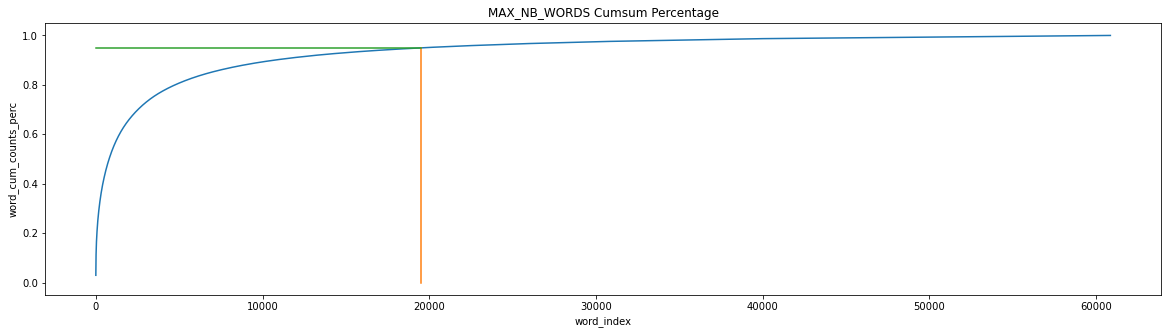

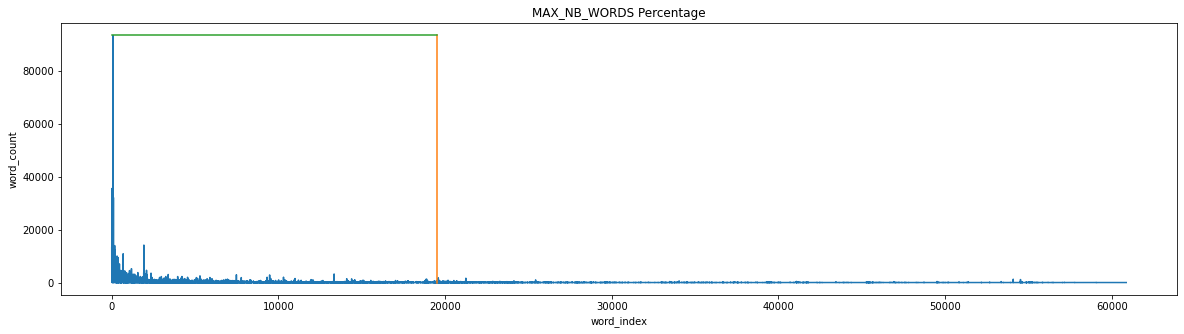

Cut index with 95.0 % of corpus:  19534 

    index    word  count
0      76       i  93291
1       8       s  35505
2     103     the  32095
3      51       t  30999
4      50       n  30887
5       7      it  25723
6    1931       x  14152
7     178      do  13957
8       0      re  13189
9      11     you  12828
10    187    this  12361
11    181  people  11668
12    687    like  10868
13    168      if  10808
14    322       a  10019
15    118      in   9599
16     12    know   9498
17    379       m   9465
18     27   think   8326
19    166      is   8275


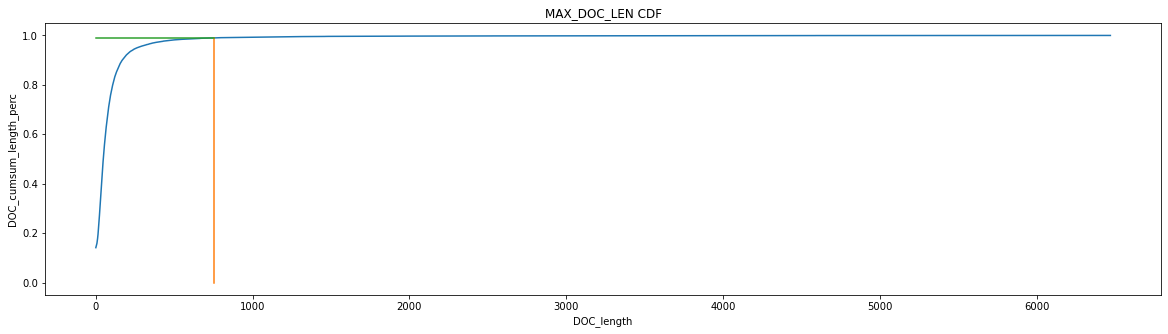

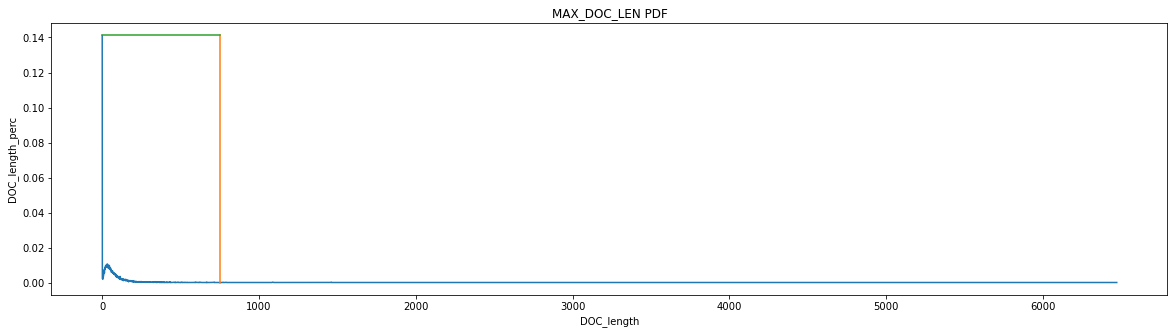

Cut index with 99.0 % of corpus:  754


In [2]:
####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.99
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [3]:
####################################
### train val test split
####################################
x_train_val, y_train_val, x_test, y_test = train_text, train_label, test_text, test_label
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

####################################
### preprocessor for NN input
####################################
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, train_text, filters=filters)
x_train = processor.generate_seq(x_train)
x_val = processor.generate_seq(x_val)
x_test = processor.generate_seq(x_test)
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)


print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))


info = pd.concat([y_train.value_counts(), y_val.value_counts(), y_val.value_counts()/y_train.value_counts(), y_train.value_counts()/y_train.size\
                 , y_test.value_counts(), y_test.value_counts()/y_test.size], axis=1)
info.index = labels
info.columns = ['tr_size', 'val_size', 'val_ratio', 'tr_prop', 'test_size', 'test_prop']
info

Shape of x_tr: (28351, 754)
Shape of y_tr: (28351,)
Shape of x_val: (7088, 754)
Shape of y_val: (7088,)
Shape of x_test: (7761, 754)
Shape of y_test: (7761,)


,tr_size,val_size,val_ratio,tr_prop,test_size,test_prop
alt.atheism,1330,332,0.249624,0.046912,319,0.041103
comp.graphics,1401,351,0.250535,0.049416,389,0.050122
comp.os.ms-windows.misc,1418,355,0.250353,0.050016,394,0.050767
comp.sys.ibm.pc.hardware,1416,354,0.250000,0.049945,392,0.050509
comp.sys.mac.hardware,1387,347,0.250180,0.048922,385,0.049607
comp.windows.x,1423,356,0.250176,0.050192,395,0.050896
misc.forsale,1404,351,0.250000,0.049522,390,0.050251
rec.autos,1423,356,0.250176,0.050192,395,0.050896
rec.motorcycles,1435,359,0.250174,0.050615,398,0.051282
rec.sport.baseball,1433,358,0.249826,0.050545,397,0.051153


In [4]:
from collections import Counter, defaultdict
from gensim.models import word2vec
# from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from nltk import bigrams, trigrams, ngrams
from nltk.corpus import reuters, stopwords
from sklearn import preprocessing
# from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim.downloader as api
import glob
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nltk, string
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string, os
import tensorflow as tf
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# TextCNN

## notes:

In [5]:
# define Model for classification

def model_Create(FS, NF, EMB, MDL, MNW, PWV=None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model_l2(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB,
                        NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    # Hyperparameters: MAX_DOC_LEN
    q1_input = Input(shape=(MDL,), name='q1_input')
    encode_input1 = cnn_box(q1_input)
    # half_features = int(len(FS)*NF/2)*10
    x = Dense(384, activation='relu', name='half_features')(encode_input1)
    x = Dropout(rate=0.3, name='dropout1')(x)
#     x = Dense(256, activation='relu', name='dense1')(x)
#     x = Dropout(rate=0.3, name='dropou2')(x)
    x = Dense(128, activation='relu', name='dense2')(x)
    x = Dropout(rate=0.3, name='dropout3')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    x = Dropout(rate=0.3, name='dropout4')(x)
    pred = Dense(20, activation='softmax', name='Prediction')(x)
    model = Model(inputs=q1_input, outputs=pred)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model


EMBEDDING_DIM = 200
# W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
W2V = None
trainable_switch = True

In [6]:
# Set hyper parameters
FILTER_SIZES = [1, 2, 3, 4, 5]
NUM_FILTERS = 32

# OPT = optimizers.Adam(learning_rate=0.005)
OPT = optimizers.RMSprop(learning_rate=0.001) # 'RMSprop'
PWV = W2V
model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
                     MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, 
                     optimizer=OPT, trainable_switch=trainable_switch)

In [7]:
# visual_textCNN(model)

In [8]:
BATCH_SIZE = 128
NUM_EPOCHES = 10  # 20步以上
patience = 20

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_2'
BEST_MODEL_FILEPATH = BestModel_Name

earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
model.load_weights(BestModel_Name)

Epoch 1/10
222/222 [==============================] - 25s 92ms/step - loss: 2.6684 - sparse_categorical_accuracy: 0.1213 - val_loss: 2.2722 - val_sparse_categorical_accuracy: 0.2437

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.24365, saving model to testBest_GS_2
INFO:tensorflow:Assets written to: testBest_GS_2\assets
Epoch 2/10
222/222 [==============================] - 20s 89ms/step - loss: 1.7974 - sparse_categorical_accuracy: 0.3735 - val_loss: 1.7033 - val_sparse_categorical_accuracy: 0.4590

Epoch 00002: val_sparse_categorical_accuracy improved from 0.24365 to 0.45896, saving model to testBest_GS_2
INFO:tensorflow:Assets written to: testBest_GS_2\assets
Epoch 3/10
222/222 [==============================] - 20s 88ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.6136 - val_loss: 1.5482 - val_sparse_categorical_accuracy: 0.5662

Epoch 00003: val_sparse_categorical_accuracy improved from 0.45896 to 0.56616, saving model to testBest_GS_2
INFO:tensorflow

loss val_loss


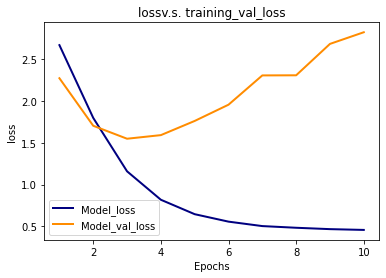

sparse_categorical_accuracy val_sparse_categorical_accuracy


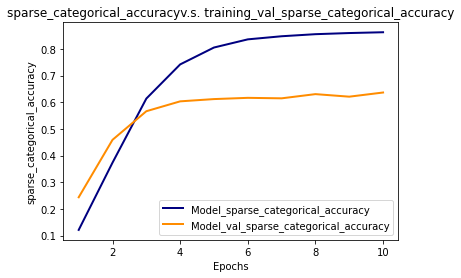

                          precision    recall  f1-score   support

             alt.atheism       0.59      0.56      0.58       319
           comp.graphics       0.51      0.63      0.56       389
 comp.os.ms-windows.misc       0.49      0.55      0.52       394
comp.sys.ibm.pc.hardware       0.54      0.58      0.56       392
   comp.sys.mac.hardware       0.62      0.67      0.65       385
          comp.windows.x       0.70      0.57      0.63       395
            misc.forsale       0.49      0.70      0.58       390
               rec.autos       0.60      0.66      0.63       395
         rec.motorcycles       0.71      0.63      0.67       398
      rec.sport.baseball       0.67      0.79      0.72       397
        rec.sport.hockey       0.95      0.70      0.81       827
               sci.crypt       0.81      0.82      0.82       396
         sci.electronics       0.64      0.50      0.56       393
                 sci.med       0.53      0.68      0.59       198
         

In [9]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

loss val_loss


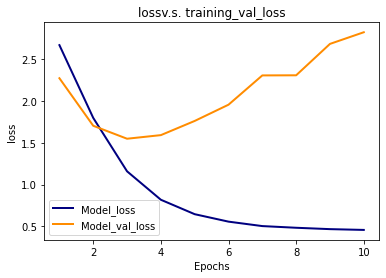

sparse_categorical_accuracy val_sparse_categorical_accuracy


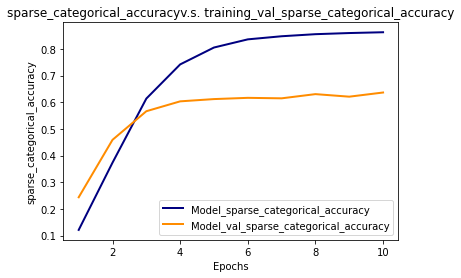

                          precision    recall  f1-score   support

             alt.atheism       0.59      0.56      0.58       319
           comp.graphics       0.51      0.63      0.56       389
 comp.os.ms-windows.misc       0.49      0.55      0.52       394
comp.sys.ibm.pc.hardware       0.54      0.58      0.56       392
   comp.sys.mac.hardware       0.62      0.67      0.65       385
          comp.windows.x       0.70      0.57      0.63       395
            misc.forsale       0.49      0.70      0.58       390
               rec.autos       0.60      0.66      0.63       395
         rec.motorcycles       0.71      0.63      0.67       398
      rec.sport.baseball       0.67      0.79      0.72       397
        rec.sport.hockey       0.95      0.70      0.81       827
               sci.crypt       0.81      0.82      0.82       396
         sci.electronics       0.64      0.50      0.56       393
                 sci.med       0.53      0.68      0.59       198
         

In [10]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

In [11]:
y_pred = model.predict(x_train)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(train_label, np.argmax(y_pred, axis=1), target_names=labels))

ValueError: Found input variables with inconsistent numbers of samples: [35439, 28351]

# LSTM

In [ ]:
# from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPooling1D, GlobalMaxPooling2D

# def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
#     model = Sequential()
#     model.add(Embedding(input_dim=MNW, output_dim=EMB, embeddings_initializer='uniform', mask_zero=True, input_length=MDL))
#     model.add(Flatten())   
# #     model.add(GlobalMaxPooling2D()) # downsampling
# #     model.add(SpatialDropout1D(0.2))    
#     model.add(Dense(1024, activation='relu'))   
#     model.add(Dense(512, activation='relu'))   
#     model.add(Dense(128, activation='relu'))   
#     model.add(Dense(64, activation='relu'))   
#     # model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dense(20, activation='softmax'))   
#     model.compile(optimizer=optimizer,
#           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#           metrics=[keras.metrics.SparseCategoricalAccuracy()])
#     return model

# model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
#                      MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, trainable_switch=trainable_switch)

In [ ]:
# visual_textCNN(model)

In [ ]:
# EMBEDDING_DIM = 200
# # W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# # W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
# trainable_switch = True
# W2V = None

In [ ]:
# BATCH_SIZE = 64
# NUM_EPOCHES = 10  # patience=20
# patience = 30

# BestModel_Name = 'text_CNN.h5'
# BEST_MODEL_FILEPATH = BestModel_Name

# earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
# checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# model.load_weights(BestModel_Name)

In [ ]:
# #### classification Report
# history_plot(history)
# y_pred = model.predict(x_test)
# # print(classification_report(y_test, np.argmax(y_pred, axis=1)))
# print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
# scores = model.evaluate(x_test, y_test, verbose=2)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print( "\n\n\n")